# Furman University - Spring Course Density Analysis
This notebook takes a dataset of course information for the Spring of 2017 and determines 
the frequency of certain department courses throughout the week. This data is presented 
as a stacked area chart and saved.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpldate
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
plt.style.use('ggplot')
import imageio

In [2]:
course_df = pd.read_csv('allSpringCourses.csv')

#Remove all rows except for the lecture rows
course_df = course_df.loc[course_df['Instructional Method'] == 'LEC',]
course_df.reset_index(inplace=True, drop=True)
course_df.head()

,Term,Section,Former,Title,Credits,Instructional Method,Location,Start Date,End Date,Meeting Days,Start Time,End Time,Instructor(s),Seats Remaining,GERS,Purpose,Prequisites,Notes,Sort,Courses ID
0,Spring 2017 - Day,ACC-111-01,ACC-23,Financial Accounting Prncpls,4.0,LEC,HIP 202,01/09/17,04/25/17,MWF,10:30AM,11:20AM,Dr. Marion E. McHugh,FULL,NaN,undergraduate day,NaN,NaN,1,2621.0
1,Spring 2017 - Day,ACC-111-02,ACC-23,Financial Accounting Prncpls,4.0,LEC,HIP 202,01/09/17,04/25/17,MWF,11:30AM,12:20PM,Dr. Marion E. McHugh,FULL,NaN,undergraduate day,NaN,NaN,1,2621.0
2,Spring 2017 - Day,ACC-311-01,ACC-41,Intrmd Financial Accounting I,4.0,LEC,HIP 204,01/09/17,04/25/17,MWF,10:30AM,11:20AM,Ms. Sandra G. Roberson,FULL,NaN,undergraduate day,ACC-111,NaN,1,2623.0
3,Spring 2017 - Day,ACC-320-01,ACC-43,Cost Accounting,4.0,LEC,HIP 202,01/09/17,04/25/17,TR,01:00PM,02:15PM,Bill Merkt,1,NaN,undergraduate day,ACC-311,NaN,1,2625.0
4,Spring 2017 - Day,ACC-330-01,ACC-45,Auditing,4.0,LEC,HIP 104,01/09/17,04/25/17,MWF,01:30PM,02:20PM,Dr. Marion E. McHugh,FULL,NaN,undergraduate day,ACC-312,NaN,1,2626.0


In [3]:
#Convert times to datetimes
course_df.loc[:, 'Start Time'] = pd.to_datetime(course_df['Start Time'])
course_df.loc[:, 'End Time'] = pd.to_datetime(course_df['End Time'])
# Remove cells with NaT from start time and end time columns
course_df = course_df[pd.notnull(course_df['Start Time'])]
course_df = course_df[pd.notnull(course_df['End Time'])]
course_df.reset_index(inplace=True, drop=True)

In [4]:
courseLong_df = pd.DataFrame()
# For each course in the data set, and for every 5 minutes, from Start Time to End Time of the
# course, copy the data for the course and insert the time to create a 'long' data set.
for i in range(len(course_df.index)):
    time_range = pd.date_range(course_df['Start Time'][i], course_df['End Time'][i], freq='5T').time
    # Repeat the data for that row once for every time in time_range
    temp_df = pd.concat([course_df.iloc[i]]*len(time_range), axis=1, ignore_index=True).transpose()
    temp_df.loc[:, 'Time'] = pd.Series(time_range)
    courseLong_df = courseLong_df.append(temp_df, ignore_index=True)

In [5]:
# Preview what was just done...
courseLong_df.loc[:, ["Title", "Time"]].head()

,Title,Time
0,Financial Accounting Prncpls,10:30:00
1,Financial Accounting Prncpls,10:35:00
2,Financial Accounting Prncpls,10:40:00
3,Financial Accounting Prncpls,10:45:00
4,Financial Accounting Prncpls,10:50:00


In [6]:
# Parse the 3 letter department name and 2 digit section number from the Section column
courseLong_df.loc[:, 'Department'] = courseLong_df.loc[:, 'Section'].apply(lambda x: x[0:3])
courseLong_df.loc[:, 'Section'] = courseLong_df.loc[:, 'Section'].apply(lambda x: x[-2:])
courseLong_df.drop('Term', axis=1, inplace=True)

In [7]:
# separate courses into days that the course is taught
monday_df = courseLong_df[courseLong_df.loc[:,'Meeting Days'].str.contains('M')]
tuesday_df = courseLong_df[courseLong_df.loc[:,'Meeting Days'].str.contains('T')]
wednesday_df = courseLong_df[courseLong_df.loc[:,'Meeting Days'].str.contains('W')]
thursday_df = courseLong_df[courseLong_df.loc[:,'Meeting Days'].str.contains('R')]
friday_df = courseLong_df[courseLong_df.loc[:,'Meeting Days'].str.contains('F')]

In [8]:
# get the frequency of departments at each time, this tells us how many classes of that
# department are being taught at that time.
mondayTime_df = monday_df.groupby(['Time', 'Department']).size().reset_index(name="Count")
tuesdayTime_df = tuesday_df.groupby(['Time', 'Department']).size().reset_index(name="Count")
wednesdayTime_df = wednesday_df.groupby(['Time', 'Department']).size().reset_index(name="Count")
thursdayTime_df = thursday_df.groupby(['Time', 'Department']).size().reset_index(name="Count")
fridayTime_df = friday_df.groupby(['Time', 'Department']).size().reset_index(name="Count")

# preview a the start of a day
tuesdayTime_df.head()

,Time,Department,Count
0,07:30:00,PHL,1
1,07:35:00,PHL,1
2,07:40:00,PHL,1
3,07:45:00,PHL,1
4,07:50:00,PHL,1


In [9]:
time_range = pd.DataFrame(pd.date_range('7:30', '20:30', freq='5T').time, columns=['Time'])
all_depts = courseLong_df['Department'].unique()
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
ind = np.arange(len(time_range))

mondayCounts_df = pd.DataFrame()
tuesdayCounts_df = pd.DataFrame()
wednesdayCounts_df = pd.DataFrame()
thursdayCounts_df = pd.DataFrame()
fridayCounts_df = pd.DataFrame()

# Create a sparse dataset, where for every 5 minute time interval a department column has
# a count of how many classes are being taught at that time, including the times when 0 classes
# are being taught at that time...
# This is accomplished by doing a merge between the list of ALL times, and the department's
# time counts that were found in the previous cell.
for i, dept in enumerate(all_depts):
    mondayCounts_df[dept] = time_range.merge(mondayTime_df.loc[mondayTime_df.loc[:,'Department'] == dept], how='left', left_on='Time', right_on='Time').fillna(0)['Count']
    tuesdayCounts_df[dept] = time_range.merge(tuesdayTime_df.loc[tuesdayTime_df.loc[:,'Department'] == dept], how='left', left_on='Time', right_on='Time').fillna(0)['Count']
    wednesdayCounts_df[dept] = time_range.merge(wednesdayTime_df.loc[wednesdayTime_df.loc[:,'Department'] == dept], how='left', left_on='Time', right_on='Time').fillna(0)['Count']
    thursdayCounts_df[dept] = time_range.merge(thursdayTime_df.loc[thursdayTime_df.loc[:,'Department'] == dept], how='left', left_on='Time', right_on='Time').fillna(0)['Count']
    fridayCounts_df[dept] = time_range.merge(fridayTime_df.loc[fridayTime_df.loc[:,'Department'] == dept], how='left', left_on='Time', right_on='Time').fillna(0)['Count']

# Preview a day to see that it is now a sparse dataset
thursdayCounts_df

,ACC,ANT,ART,AST,BIO,BUS,CHM,CHN,COM,CSC,...,PSC,PSY,PVS,REL,SCI,SOC,SPN,SUS,THA,WGS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


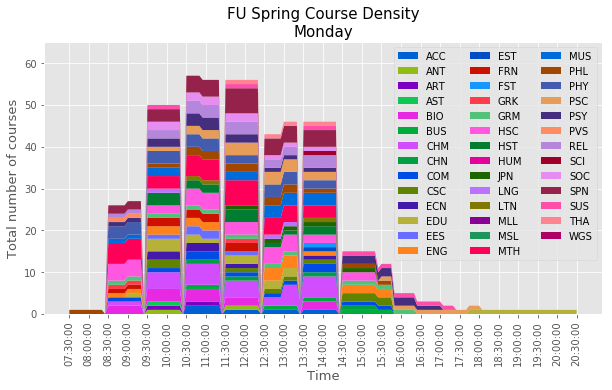

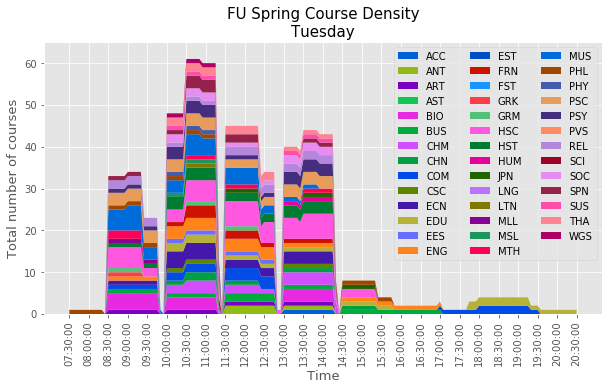

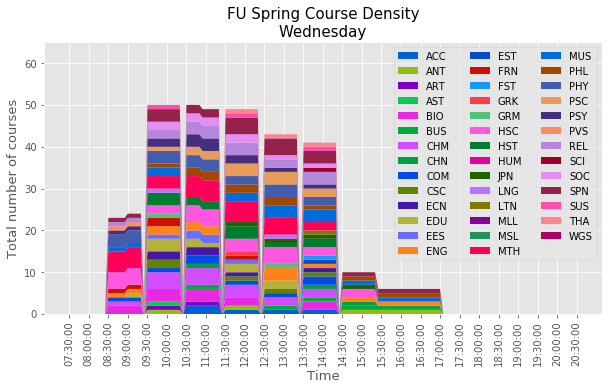

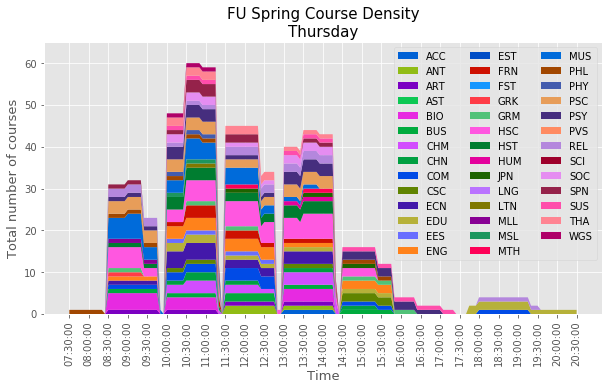

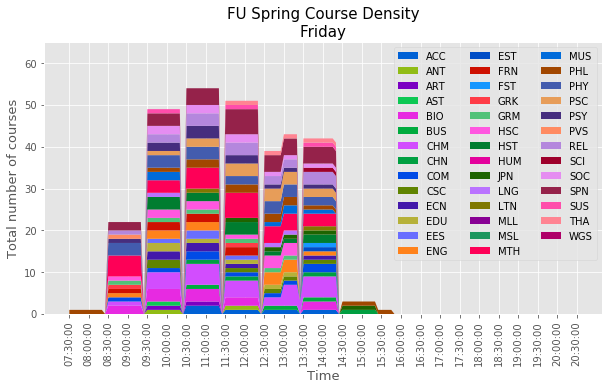

In [10]:
# Draw a stacked area plot for each weekday
# Colors generated using http://tools.medialab.sciences-po.fr/iwanthue/
color_list = ["#0061d5", "#91bc15", "#7b00c2", "#0dc853", "#e72ae1", "#00ab3e", "#d24dfe", "#009f41", "#014be6", "#608400", "#4318aa", "#b6b139", "#696eff", "#ff821b", "#004dc6", "#ce1000", "#1697ff", "#ff3c47", "#51c278", "#ff57e0", "#007d30", "#e4019c", "#1e6400", "#ba73ff", "#807800", "#880094", "#1d965e", "#fe0057", "#006bda", "#a14700", "#435cae", "#e79d59", "#462e7e", "#ff8b62", "#b487dd", "#9e002b", "#e58df1", "#95224a", "#ff4dab", "#ff8492", "#af0068"]

patch_colors = [Rectangle((0, 0), 1, 1, fc=color) for color in color_list]
week_dfs = [mondayCounts_df, tuesdayCounts_df, wednesdayCounts_df, thursdayCounts_df, fridayCounts_df]

images = []

for df, wk in zip(week_dfs, weekdays):
    plt.figure(figsize=(10,5))
    plt.stackplot(ind, df.transpose(), colors=color_list)
    plt.xticks(ind[::6], time_range.loc[::6,'Time'], rotation='vertical')
    plt.ylim(ymax=65)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('Total number of courses', fontsize=13)
    plt.title('FU Spring Course Density\n'+wk, fontsize=15)
    plt.legend(patch_colors, all_depts, ncol=3)
    plt.savefig(wk+'.png', bbox_inches="tight")#, dpi = 300)
    plt.show()
    
for wk in weekdays:  
    images.append(imageio.imread(wk+'.png'))
imageio.mimsave('courseDensity.gif', images, duration=1.5)